# Transform a PyTorch model to onnx

In this tutorial, I want to show how easily you can transform a PyTorch model to the onnx format. But first of all, why would you want to do that? There are several reasons in my experience when this might come in handy for you:
- your development area is different from your production area. In my experience, this is often the case. When we have huge data on which to do inference in batches, it is often not the best idea to first shift your data from one source towards your python-server, do the inference there and then put the data back again. onnx can make you use your Deep Learning models directly where your data is stored which is a huge benefit.
- onnx runs on Java via their API, meaning you can train your model with Python but deploy it on Java. This makes a huge difference because you can then deploy your model for example directly in your cluster.
- onnx supports all of the popular Deep Learning frameworks like PyTorch, TensorFlow or Caffe (and a lot more). That means in teams where some feel more confortable using TensorFlow and other feel more comfortable using PyTorch, the deployment process can still be the same.


In [40]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.onnx

import matplotlib.pyplot as plt

In a previous tutorial I already showed you how powerful convolutional neural networks are when it comes to timeseries. I used the Italy Power demand dataset to do a classification task, which was to distinguish which day stems from. 
To show you how to deploy your model I will use this model trained on CPU with PyTorch and show you how then to save it as an onnx model. The way onnx works is that it first needs a "sample" of one example data point (tensor) with which we once do the inference part. So let's first load the data and just take the first example for which we want to make a prediction.

In [2]:
df_train = pd.read_csv('Data/ItalyPowerDemand_TRAIN.txt', header=None,delim_whitespace=True)
x_train = df_train.iloc[:, 1:].values.reshape(-1, 1, 24)
x_train[0]

array([[-0.71051757, -1.1833204 , -1.3724416 , -1.5930829 , -1.4670021 ,
        -1.3724416 , -1.0887599 ,  0.04596695,  0.92853223,  1.0861332 ,
         1.2752543 ,  0.96005242,  0.61333034,  0.01444676, -0.6474772 ,
        -0.26923494, -0.20619456,  0.61333034,  1.3698149 ,  1.4643754 ,
         1.054613  ,  0.58181015,  0.1720477 , -0.26923494]])

Just as a reminder, this numpy array represents the power usage within 24 hours, and we tried to predict whether this day is from Oct to March (inclusive) or from April to September.

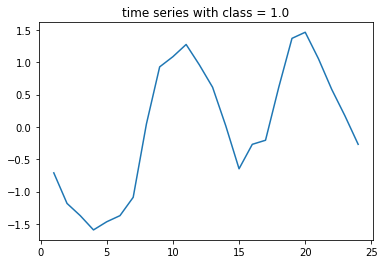

In [5]:
df_train.iloc[0, 1:].plot.line(title=f'time series with class = {df_train.iloc[0, 0]}');

We now transform this numpy array to a PyTorch tensor. The only thing we need to keep in mind from building our model is that the tensor has to follow a certain shape. Right now this shape looks like so:

In [6]:
x_train[0].shape

(1, 24)

However, the model expects the shape like so: [batch_size, no_of_variables, no_of_observations]. In our case, we want the batch_size to be 1, we only have 1 variable over which we want to predict (power usage) and we have 24 observations, one for each hour. Also, we need to make the tensor of type float in this case, because when training the model we used the float type as input.

In [35]:
x_tensor = torch.from_numpy(x_train[0].reshape(1, 1, 24)).float()

Now we need to reload our model. Best practice for saving models is to only save the state_dict(). This however means when realoding the model, we first need to define the "skeleton" of the model if you will, which will then be updated by the corresponding weights and biases from the saved state_dict(). Again, if you haven't read the tutorial on how to build the model, I highly recommend to read that again.

In [36]:
class CostumConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [nn.Conv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)
    
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""
    def __init__(self, keep_batch_dim=True):
            super().__init__()
            self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            CostumConv1d(raw_ni,  128, 23, 1, 0, drop=drop),
            nn.MaxPool1d(2, stride=2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(128, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))
        
        self.out = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        out = self.out(raw_out)
        return out

Remember, we only have one variable with which we predict one of two classes (either 0 or 1).

In [37]:
device = torch.device('cpu')
no_variables = 1
num_classes = 2
model = Classifier(no_variables, num_classes).to(device)
model.load_state_dict(torch.load('best.pth'))

<All keys matched successfully>

We're already almost done. Last thing missing is the inference part. To do so, we first have to put the mode in evaluation mode (otherwise it expects the target variable as an input to the model as well) and we also for faster inference later on tell the model not to calculate the gradients each time.

In [34]:
model.eval()
with torch.no_grad():
    output = model(x_tensor.to(device))

In [38]:
output

tensor([[0.0232, 0.0089]])

Now we're ready to save our model as a onnx model. Keep in mind that any changes done to the output (like applying a sigmoid function for example) will not be saved in the onnx model. Later operations then need to be done where you apply the model, for example when using it in a Java set up you need to use the Java functionality for sigmoid.

In [41]:
torch.onnx.export(model,
                  x_tensor,
                  'onnx_model.onnx',
                  export_params=True,
                  opset_version=10)

d:\PythonProjects\python_to_onnx\venv_onnx\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


The UserWarning we're getting here is outdated, with pytorch 1.9 the version is stable and you can savely use this model. (this warning should be removed with version 1.9.1, current date: 2021-08-28)

And that's it! We now have saved our model with onnx, ready to be deployed on other frameworks directly. In the next tutorial, I want to show you how to use this onnx model and make it run on Java.

Lasse